In [1]:
CUREGN = [
    "2_6063_A_0045151",
    "2_4827_A_0045173",
    "2_6088_A_0037223",
    "2_6094_A_0039851",
    "2_6097_A_0045196",
    "2_4839_A_0039862",
    "2_4841_A_0045207",
    "2_4848_A_0039884",
    "2_6128_A_0037277",
    "2_6130_A_0037288"
]

JEFF = [
    "015_TRI_235805",
    "16-010-02_TRI_11632_copy",
    "16-032-02_TRI_11628_copy",
    "KL-0023191_L03_TRIS_272723",
]

In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import os
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import scipy
from post_process_utils import post_process
from extract_feature_utils import extract_features
from stat_vis_utils import plot_hist_w_two_list

In [3]:
DIR_WSI = "/Users/jinzhou/Desktop/Paper_MIA/data/wsi"
DIR_ANN = "/Users/jinzhou/Desktop/Paper_MIA/data/ann_geojsons"
DIR_SAVE_RESULTS = "/Users/jinzhou/Desktop/Paper_MIA/results"
DIR_SAVE_FIGURE = "/Users/jinzhou/Desktop/Paper_MIA/results/figures"

## Process thickness.csv

In [4]:
PATH_STAT_MANUAL = os.path.join(DIR_SAVE_RESULTS, "thickness.json")
PATH_STAT_DL = os.path.join(DIR_SAVE_RESULTS, "thickness_dl.json")

In [5]:
# read thickness analysis
def read_df_from_csv(path_csv):
    df = pd.read_json(path_csv, orient="records", lines=True)
    return df

def clean(df_thick):

    df_thick.loc[:, 'Artery_ID'] = df_thick.loc[:, 'Artery_ID'].str.split('_').str[0]        
    # Set and WSI_Artery_ID, ignoring media and intima index
    df_thick.loc[:, 'WSI_Artery_ID'] = df_thick.loc[:, 'WSI_ID'] + '_' \
        + df_thick.loc[:, 'Artery_ID']
    # For arteries with multiple lumen/intima areas, we pick the one with maxium lumen area
#     df_thick = df_thick[df_thick.loc[:, "WSI_Artery_ID"]!="11_26609_027_005 L03 TRI_A17"]        
    return df_thick

In [6]:
df_thick = read_df_from_csv(PATH_STAT_MANUAL)
df_thick = clean(df_thick)
df_thick.shape

(914, 10)

In [7]:
df_thick.loc[:, "WSI_ID"].unique().shape

(33,)

In [8]:
df_thick_dl = read_df_from_csv(PATH_STAT_DL)
df_thick_dl = clean(df_thick_dl)
df_thick_dl.shape

(142, 14)

In [9]:
df_thick.shape


(914, 10)

In [10]:
# df_thick = df_thick.loc[df_thick.loc[:, "WSI_Artery_ID"].isin(df_thick_dl.loc[:, "WSI_Artery_ID"].values), :]

# df_thick = df_thick_dl

In [11]:
# df_thick = df_thick[df_thick.loc[:, "WSI_ID"].isin(CUREGN)]
df_thick.shape


(914, 10)

## Process "Labels.xlsx"

In [12]:
PATH_LABEL_JEFF = "/Users/jinzhou/Desktop/Paper_MIA/data/labels_jeff.csv"
PATH_LABEL_DAVID= "/Users/jinzhou/Desktop/Paper_MIA/data/labels_david.csv"


In [13]:
df_label_jeff = pd.read_csv(PATH_LABEL_JEFF).set_index("Artery_ID")
df_label_david = pd.read_csv(PATH_LABEL_DAVID).set_index("Artery_ID")

In [14]:
df_thick = df_thick.loc[df_thick.loc[:, "WSI_ID"].isin(df_label_jeff.columns), :]
print(df_thick.shape)

(914, 10)


In [15]:
df_thick = df_thick.sort_values(['Curr_Area_Lumen'], ascending=False)
df_thick = df_thick.drop_duplicates(['WSI_Artery_ID'])

In [16]:
print(df_thick.shape)

(743, 10)


In [17]:
# count = 0
# for i, wsi_id in enumerate(df_label.columns):
#     vals = df_label.loc[:, wsi_id].values
#     count = count + np.sum(vals==0 )+ np.sum(vals==1) + np.sum(vals==2)+ np.sum(vals==3)
#     print("WSI"+str(i+1), np.sum(vals==0), np.sum(vals==1), np.sum(vals==2), np.sum(vals==3))

## Post-Processing

In [18]:
def feature_extract_all(t_multi, t_open_lumen, t_mediam, t_average):

    df_features_label = pd.DataFrame(columns = [])
    to_discard = set()

    for index, row in df_thick.iterrows(): 

        # get the img
        path_artery_img = os.path.join(DIR_SAVE_FIGURE, row["WSI_ID"], row["Artery_ID"]+".png")
#         artery_img = cv2.cvtColor(cv2.imread(path_artery_img), cv2.COLOR_BGR2RGB)

        # get the measurements
        thick_media = np.array(row["Thickness_Media"])
        thick_intima = np.array(row["Thickness_Intima"])
        thick_wall = np.array([x + y if x >= 0 else x for x, y in zip(thick_media, thick_intima)])

    #     thick_wall = np.array(row["Thickness_Wall_Abs"])
        thick_media, thick_intima, thick_wall = post_process(thick_media, thick_intima, thick_wall, 
                                                            t_multi, t_open_lumen, t_mediam, t_average)
#         if -2 in thick_wall or -3 in thick_wall: # open lumen or multiple lumen/intima
#             continue
#         if -2 not in thick_wall: # open lumen or multiple lumen/intima
#             continue
#         print(row)
        if row["WSI_Artery_ID"] in ["11_26609_027_006 L02 TRI_A07", "11_26609_009_008 L10 TRI_A01",
                                   "11_26609_098_005_L4 TRI_A09", "11_26609_020_006 A15 TRI_A22"]:
            print(row["WSI_Artery_ID"])
            plot_hist_w_two_list(thick_media, thick_intima, "Thickness", None)
        features_intima, features_media, features_ratio = extract_features(thick_media, thick_intima, thick_wall)
        row_features_label = {}
        area_artery = row["Area_Media"] + row["Area_Intima"] + row["Area_Lumen"]
        row_features_label['Media Area'] = row["Area_Media"] / area_artery
        row_features_label['Intima Area'] = row["Area_Intima"] / area_artery
        row_features_label['Lumen Area'] = row["Area_Lumen"] / area_artery
        row_features_label['Ratio Intima/Media Area'] = row["Area_Intima"] / (row["Area_Media"] + row["Area_Intima"])
        row_features_label = {**row_features_label, **features_intima, **features_media, **features_ratio}
    
        row_features_label["WSI_ID"] = row["WSI_ID"]
        row_features_label["WSI_Artery_ID"] = row["WSI_Artery_ID"]
        
        row_features_label["Label"] = df_label_jeff.loc[row["Artery_ID"], row["WSI_ID"]]
        if row_features_label["Label"] != row_features_label["Label"]:
#             print(row_features_label["WSI_ID"])
            to_discard.add(row_features_label["WSI_ID"])
            continue
        if row_features_label["Intima Average"] != row_features_label["Intima Average"]:
            print(row_features_label)
              
        df_features_label = df_features_label.append(row_features_label, ignore_index=True)    
    print(to_discard)
    return df_features_label

11_26609_098_005_L4 TRI_A09


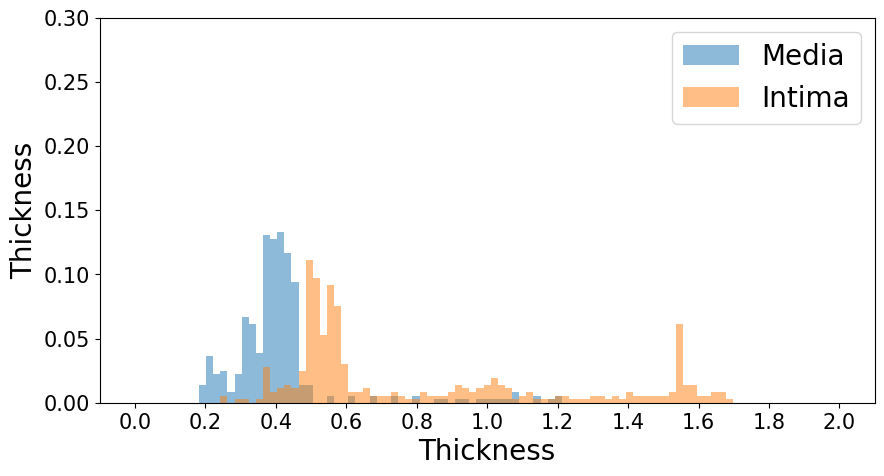

11_26609_020_006 A15 TRI_A22


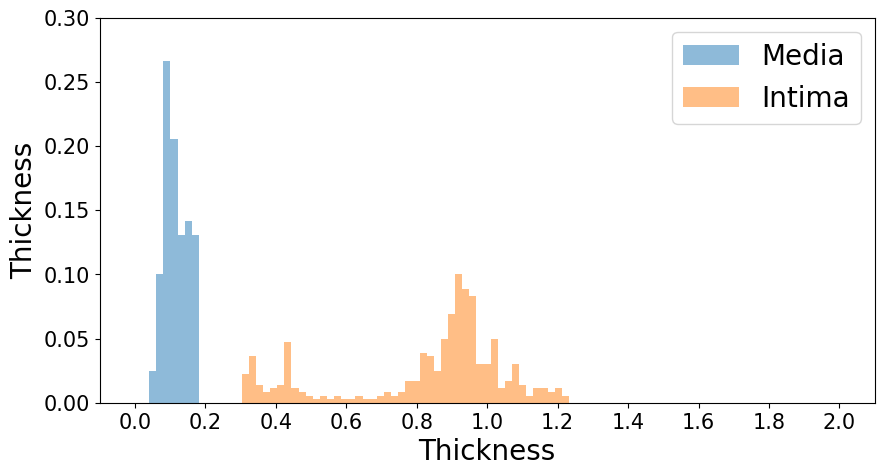

11_26609_027_006 L02 TRI_A07


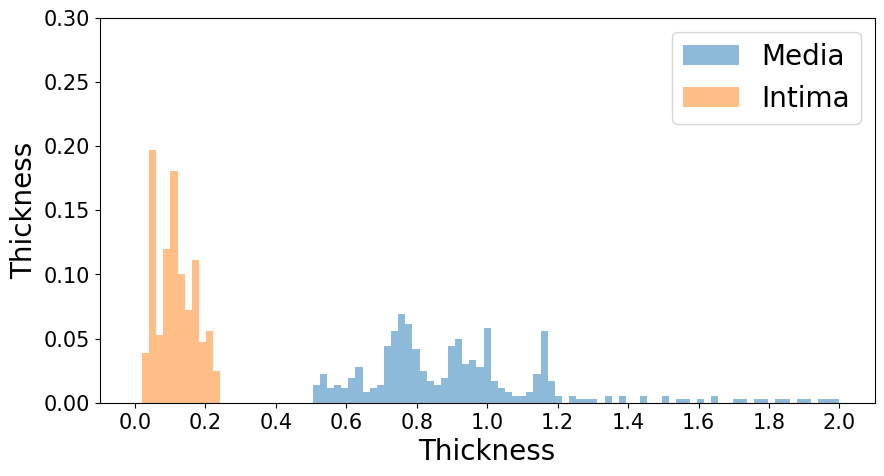

11_26609_009_008 L10 TRI_A01


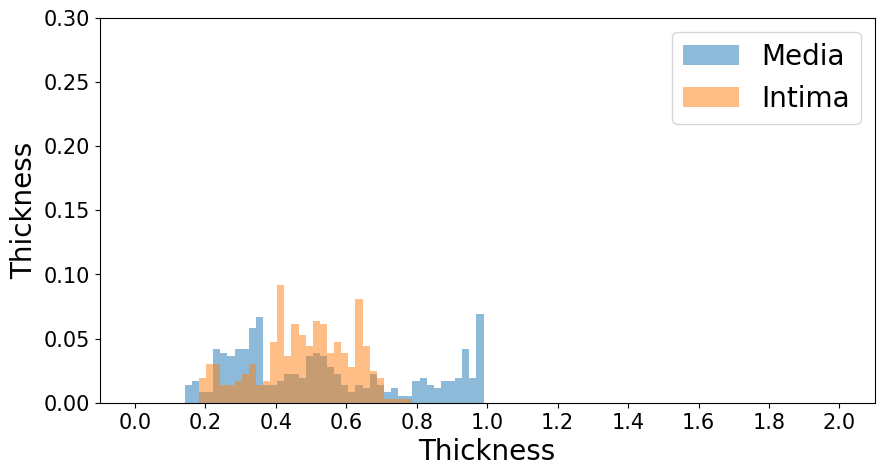

{'12_26609_022_015 L2 TRI', 'KL-0023191_L03_TRIS_272723', '2_6063_A_0045151', '12_26609_001_501 LUNK TRI', '16-010-02_TRI_11632_copy'}


In [19]:
curr_max = 0
max_combo = []
t_open_lumen = 11
t_mediam = 11
t_average = 11
t_multi = 11

df_features_label = feature_extract_all(t_multi, t_open_lumen, t_mediam, t_average)

In [20]:
# df_features_label =  df_features_label.loc[~df_features_label.loc[:, "Label"].isna(), :]
print(df_features_label.shape)

(731, 22)


## Boxtplot and Kendall Tau Analysis

In [21]:
alphabets="abcdefghijklmnopqrstuvwxyz"

def violin_plots(df_features_label, feature_names, count =0):
    num_f_src = len(feature_names)//3

    fig = plt.figure(figsize=(num_f_src* 5 , 15))
    axs = fig.subplots(3, num_f_src)
#     plt.subplots_adjust(hspace=0.2)

    rhos = []
    for i, feature_name in enumerate(feature_names):
        ax_i = axs[i//num_f_src, i - i//num_f_src * num_f_src]
        features = df_features_label.loc[:, feature_name].values
        idx_sort = features.argsort()
#         features[features>features[idx_sort][-30]] = features[idx_sort][-30]

        labels = df_features_label.loc[:, "Label"].values
        features_label_0 = features[labels==0]
        features_label_1 = features[labels==1]
        features_label_2 = features[labels==2]
        features_label_3 = features[labels==3]
        
        rho, p_val = scipy.stats.kendalltau(features, labels)
        rhos.append(rho)
        data = pd.DataFrame({'Score': labels, 'Feature Value': features})
#         sns.boxplot(x='Score', y='Feature Value', data=data, ax=ax_i)
        sns.violinplot(x='Score', y='Feature Value', data=data, ax=ax_i)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        if i %num_f_src == 0:
            ax_i.set_ylabel("Feature Value", fontsize=15)
        else:
            ax_i.set_ylabel(None)
        ax_i.set_xlabel("Arteriosclerosis Score", fontsize=15)
        ax_i.set_title("(" + alphabets[count+i] + ") " + feature_name + "\n" + r"$\gamma_{\tau}$" + "={:.2f}".format(rho) + " p<0.0001",
                         y=-0.4,pad=-14, fontsize=18)
    plt.tight_layout()
    plt.show()
    return rhos

In [22]:
feature_names = [x for x in df_features_label.columns if x not in ["WSI_Artery_ID", "Label"] ]

In [23]:
media_features = [x for x in feature_names if x.startswith("Media ")]
intima_features  = [x for x in feature_names if x.startswith("Intima ")]
ratio_features  = [x for x in feature_names if x.startswith("Ratio")] 

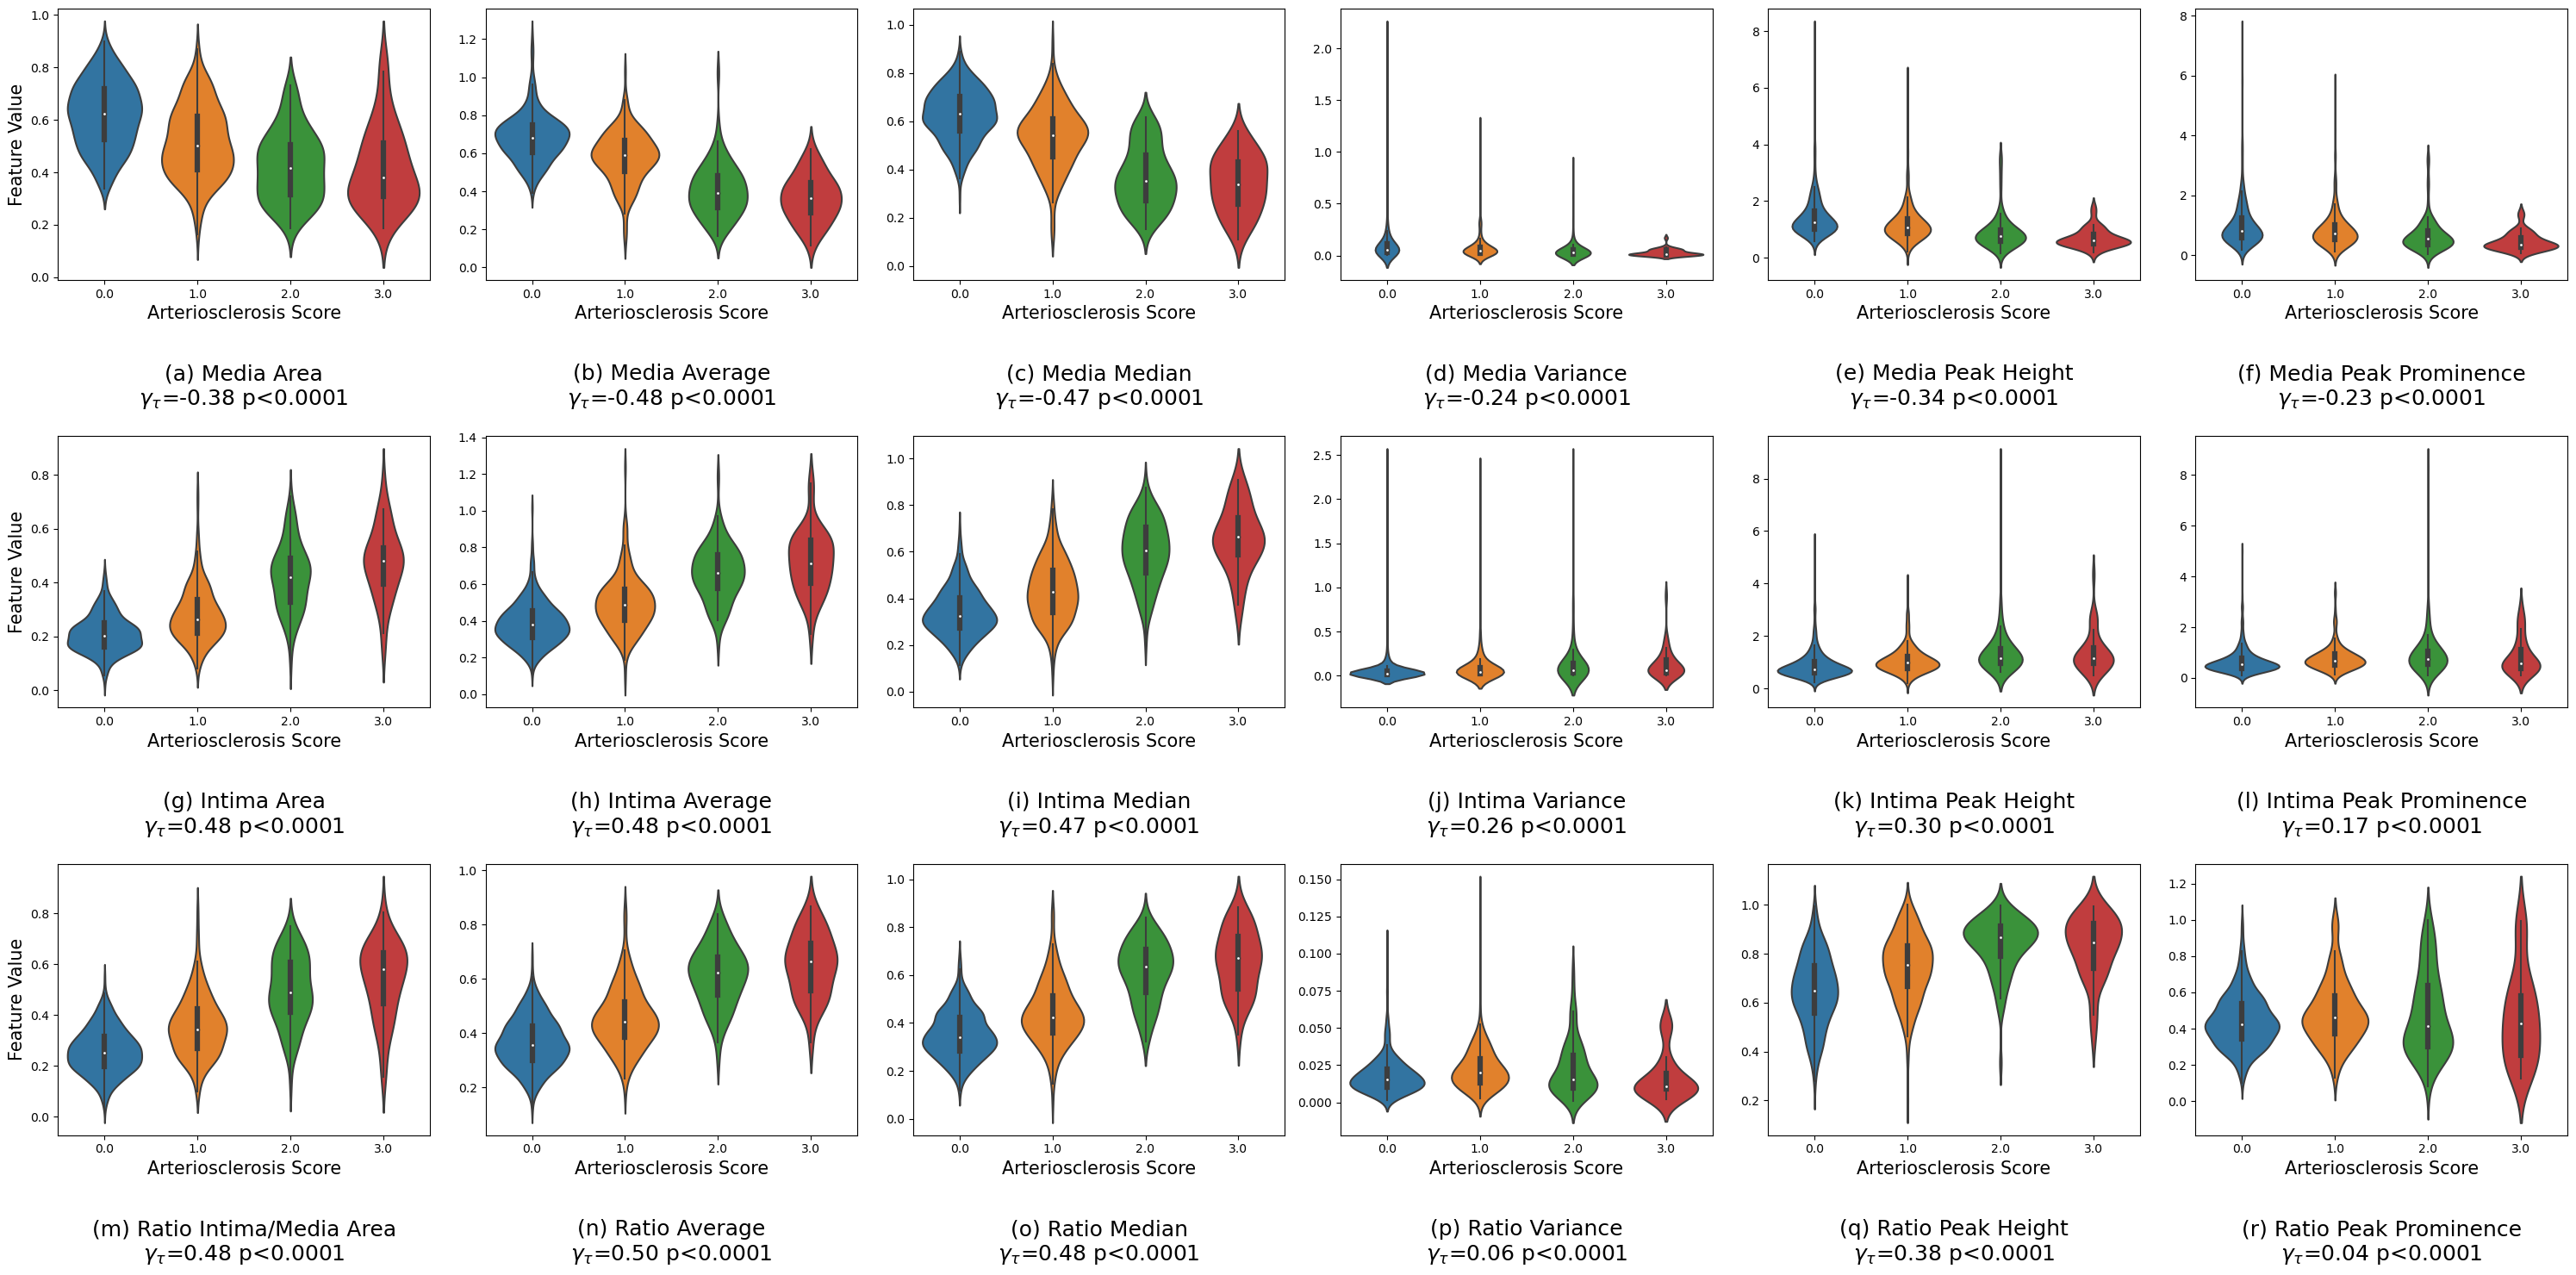

In [24]:
_ = violin_plots(df_features_label, media_features+intima_features+ratio_features)

In [25]:
# for i in df_features_label.loc[:, "WSI_ID"].unique():
#     print(i)
#     df_temp = df_features_label.loc[df_features_label.loc[:, "WSI_ID"]==i, :]
#     _ = violin_plots(df_temp, intima_features[:])
#     _ = violin_plots(df_temp, media_features[:])
#     _ =violin_plots(df_temp, ratio_features[:])

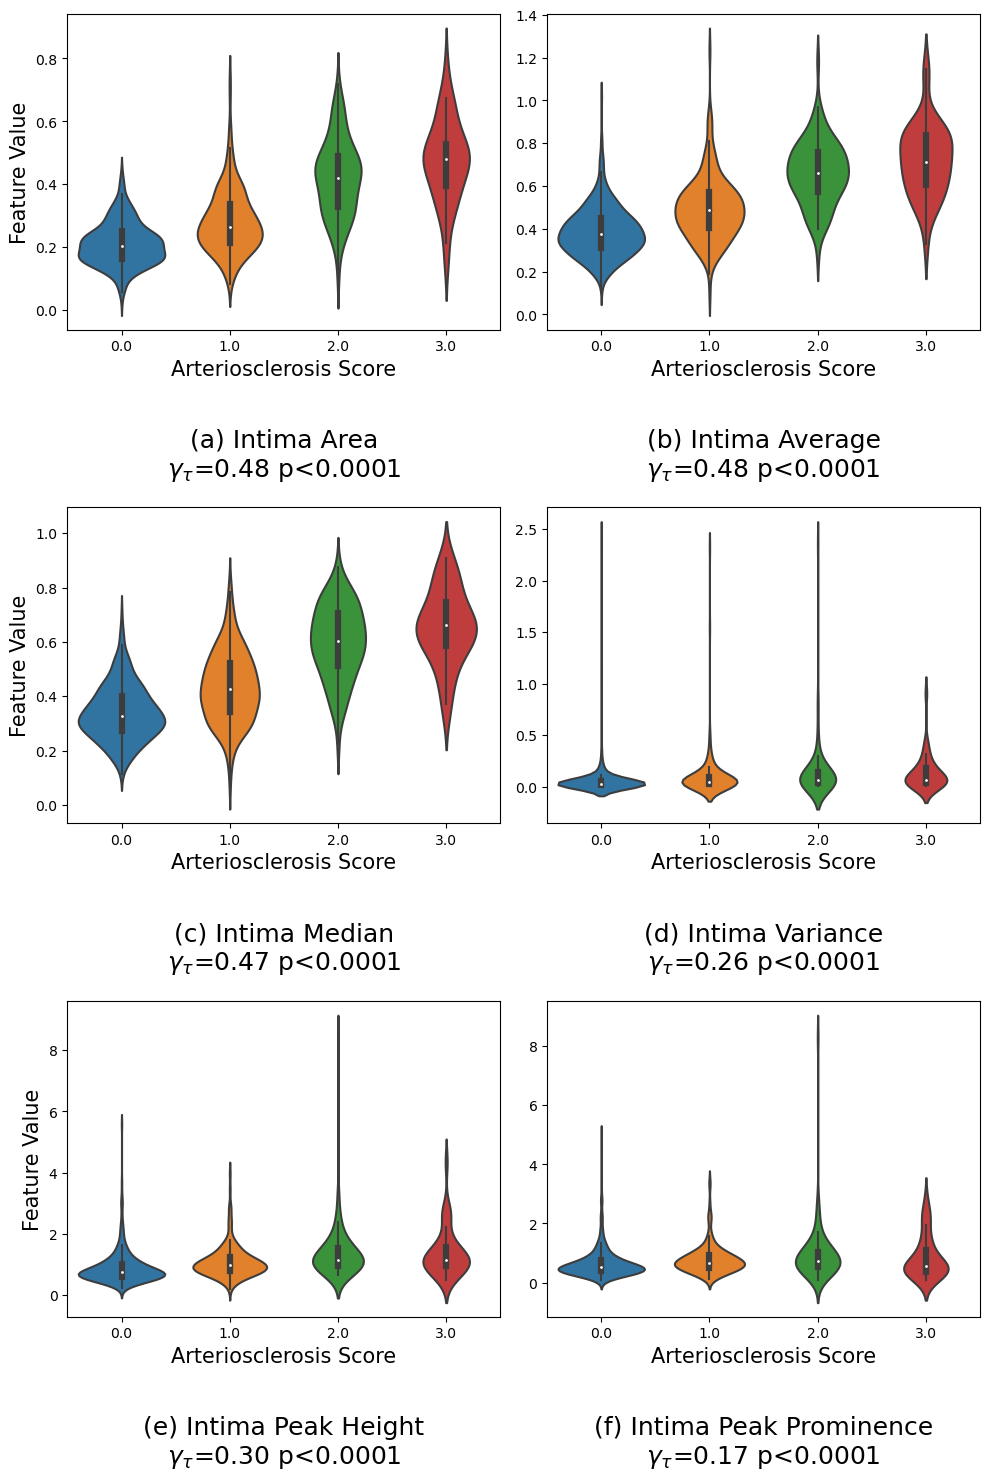

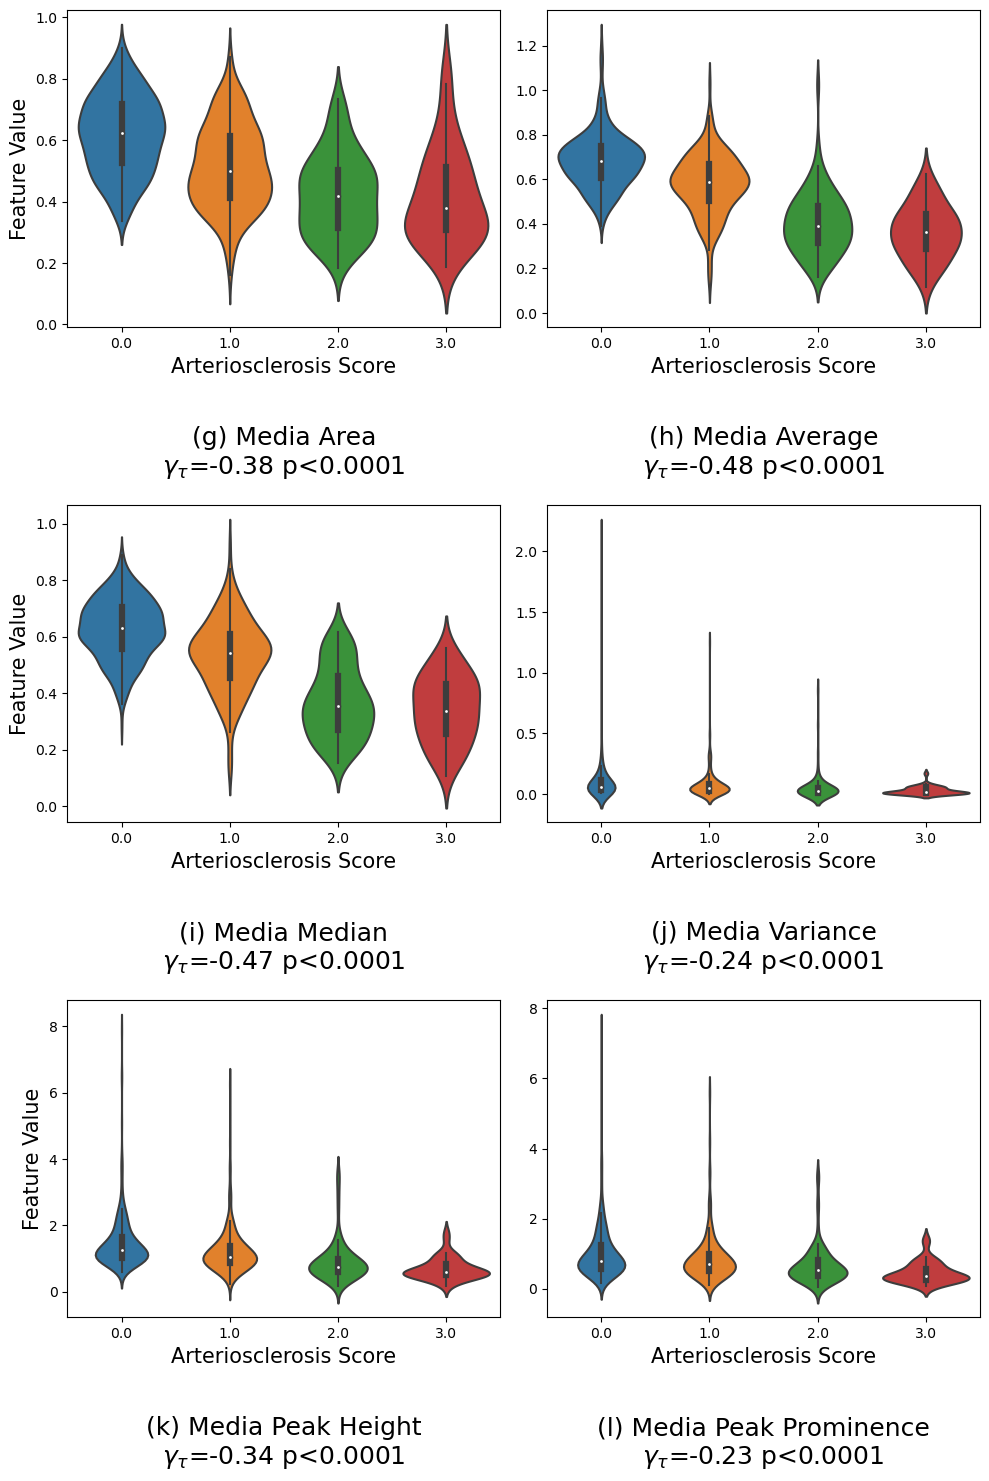

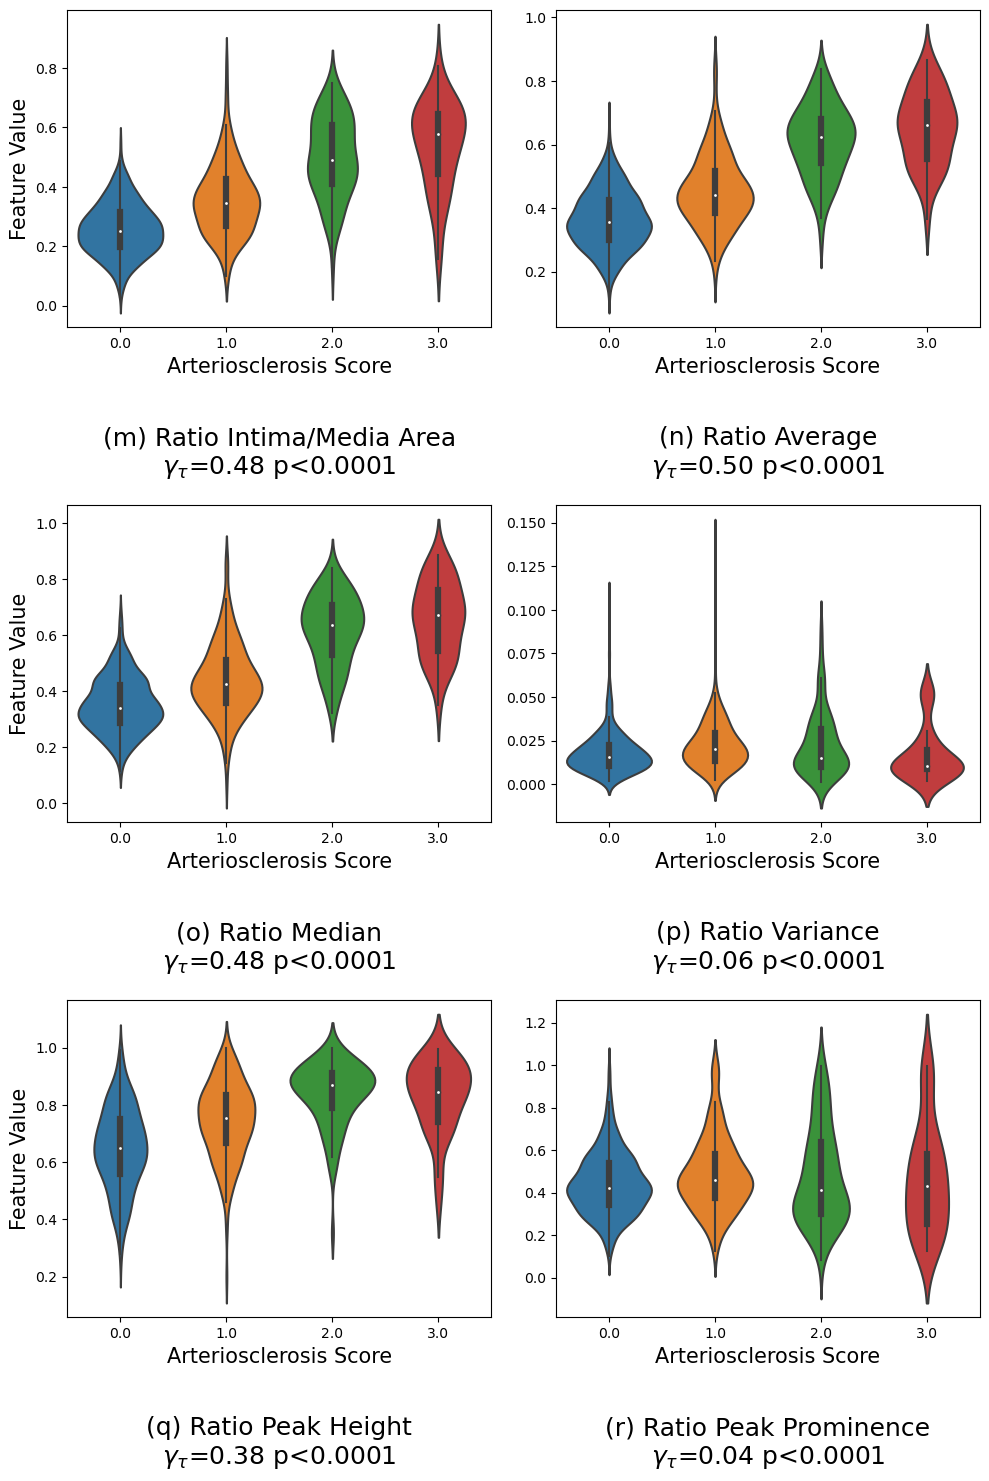

In [26]:
_ = violin_plots(df_features_label, intima_features[:], 0)
_ = violin_plots(df_features_label, media_features[:], len(intima_features))
_ = violin_plots(df_features_label, ratio_features[:], len(intima_features)+len(media_features))

In [27]:
X = df_features_label.loc[:, intima_features[-1:]+media_features[-1:]+ratio_features[-1:]].values
y = df_features_label.loc[:, "Label"].values

In [28]:
from mrmr import mrmr_regression
from sklearn.linear_model import Ridge, Lasso
from sklearn import svm
from sklearn.linear_model import LinearRegression, LogisticRegression
# for i in range(1, X.shape[1]+1):
# selected_features = mrmr_regression(X=pd.DataFrame(X), y=pd.Series(y), K=3)
ridge_model = Ridge(alpha=0.01)
# ridge_model = svm.SVC(kernel='linear')
# ridge_model = LogisticRegression()
ridge_model.fit(X, y)
print( ridge_model.score(X, y))

0.08178119857706778


In [29]:
y_pred = ridge_model.predict(X)
scipy.stats.kendalltau(y_pred, y)

from sklearn.metrics import mean_squared_log_error, r2_score, balanced_accuracy_score, accuracy_score
r2_score(y, y_pred)

0.08178119857706778

In [30]:
# All Features
# Overfit: 0.5017622624035767
# Manual: 0.3573005823083131
# DL: 0.36304507265593255

# Only Area
# Overfit: 0.46912112379135107
# Manual: 0.2729078929887465
# DL: 0.27242960819589934